In [1]:
from import_library import *

In [5]:
path = r'data/'
date = '14-05'
# date = datetime.today().strftime('%d-%m')
save_path = f'results/{date}/'
columns = ['date_time','volume','price','pct']

# Function

In [6]:
def convert_object_2_int(input):
    '''    
    Convert objects value to float ones , using in DataFrame transformation
    ----------
    Attributes:
    input: input data
    ----------
    Example:
    data['OCB_pct'] = data['OCB_pct'].apply(convert_object_2_int)
    '''    
    return int(str(input).replace(',',''))

def data_wrangling(path,file,date,save=False):
    '''    
    Get data from excel file and sum of the same date_time
    ----------
    Attributes:
    path: input data path
    file: file name
    date: 
    save: bool, default:False
    ----------
    Example:
    data['OCB_pct'] = data['OCB_pct'].apply(convert_object_2_int)
    '''    
    columns = ['date_time','volume','price','pct']
    data = pd.read_excel(path+file, 
                         sheet_name = date,
                         header = None, 
                         names=columns,
                        )
    data['volume'] = data['volume'].apply(convert_object_2_int)
    data_group=data.groupby('date_time')
    data_list = []
    total_volume = 0
    for idx,row in data_group:
        data_tmp = row
        total_volume = data_tmp['volume'].sum()
        data_list.append([data_tmp['date_time'].unique()[0],total_volume,data_tmp['price'].unique()[0],data_tmp['pct'].unique()[0]])
    new_data = pd.DataFrame(data_list, columns=columns)
    if save:
        title = f'{file[0:-3]}-{date}.csv'
        if not os.path.exists(f'{save_path}/'):
            os.makedirs( f'{save_path}/')  
        new_data.to_csv(f'{save_path}/{title}')  
    return new_data

def abnormal_trading_filtering(data,file,threshold=1000,save=False):
    '''
    Filter abnormal trading 
    ----------
    Attributes:
    data: data
    threshold: trading volume considered as abnormal ones
        default: 1000    
    ----------
    Example:
    Ex: abnormal = abnormal_trading_filtering(data,threshold=1000)
    '''
    condition = data['volume']>threshold
    abnormal = data[condition]
    if save:
        title = f'Abnormal_of_{file} '
        if not os.path.exists(f'{save_path}/'):
            os.makedirs( f'{save_path}/')        
        abnormal.to_csv(f'{save_path}/{title}.csv',index=False)        
    return abnormal 

def general_plot(data,save=False):
    df = data.copy()
    df['date_time'] = pd.to_datetime(df['date_time'],format='%H:%M:%S')
    df['date_time'] = df['date_time'].dt.strftime('%H:%M')
    fig, axes = plt.subplots(nrows=2, figsize=(12,8))
    ax = df['price'].plot(lw =2 , c='black',ax = axes[0],)
    ax.locator_params(nbins=8)
    ax.set_title('Trading Price')
    ax.grid()
    ax.set_xticklabels([])

    # for i in abnormal.index:
    #     plt.axvline(x = i, c='r', lw=2, linestyle='dashed',ax = axes[0])
    
    ax1= df['volume'].plot(ax = axes[1])
    ax1.set_xticks(df.index.values,df['date_time'],rotation=30)
    ax1.locator_params(nbins=8)
    ax1.set_title('Trading Volume')
    ax1.grid()
    if save:
        title = f'Trading Price and its Volume of {file[:-3]}-{date}.jpg'
        if not os.path.exists(f'{save_path}/'):
            os.makedirs( f'{save_path}/')
        fig.savefig(f'{save_path}/{title}', bbox_inches="tight")


def interval_analysis(data,interval = '30min',save=False):
    data['date_time'] = pd.to_datetime(data['date_time'],format='%H:%M:%S')
    # groupby time frame
    df = data.date_time.dt.floor(interval).dt.time.to_frame()\
                     .groupby('date_time').size()\
                     .reset_index(name='Count')
    range_id = [0]
    tmp = 0
    for i in df.Count.to_list():
        tmp = tmp + i
        range_id.append(tmp)
    # Statitscal Calculation of each timeframe group
    sum = []
    avg_price =[]
    i=0
    while i < len(range_id)-1:
        df_tmp = data[range_id[i]:range_id[i+1]]
        sum.append(df_tmp.volume.sum())
        avg_price.append(df_tmp.price.mean())
        i+=1
    # store in dataFrame
    df['total_volume'] = sum
    df['avg_price'] = avg_price
    # date_time processing for plotting
    df['date_time'] = pd.to_datetime(df['date_time'],format='%H:%M:%S')
    df['date_time'] = df['date_time'].dt.strftime('%H:%M')
    # Plot
    fig, axes = plt.subplots(nrows=2, figsize=(12,8))
    axes[0].plot(df.date_time,df.avg_price)
    axes[0].set_title('Average Price on 30-minute inerval')
    axes[0].set_ylabel('Avg_Price')
    axes[0].set_xticklabels([])
    axes[0].grid()
    sb.barplot(df,x='date_time',y='total_volume',ax=axes[1])
    axes[1].grid()
    axes[1].set_title('Total on 30-minute inerval')
    # save figure
    if save:
        title = f'Interval_Analysis of {file[:-3]}-{date}.jpg'
        if not os.path.exists(f'{save_path}/'):
            os.makedirs( f'{save_path}/')
        fig.savefig(f'{save_path}/{title}', bbox_inches="tight")
    #plt.savefig(f'{save_path}/{title}', bbox_inches="tight")     
    return df

# Main

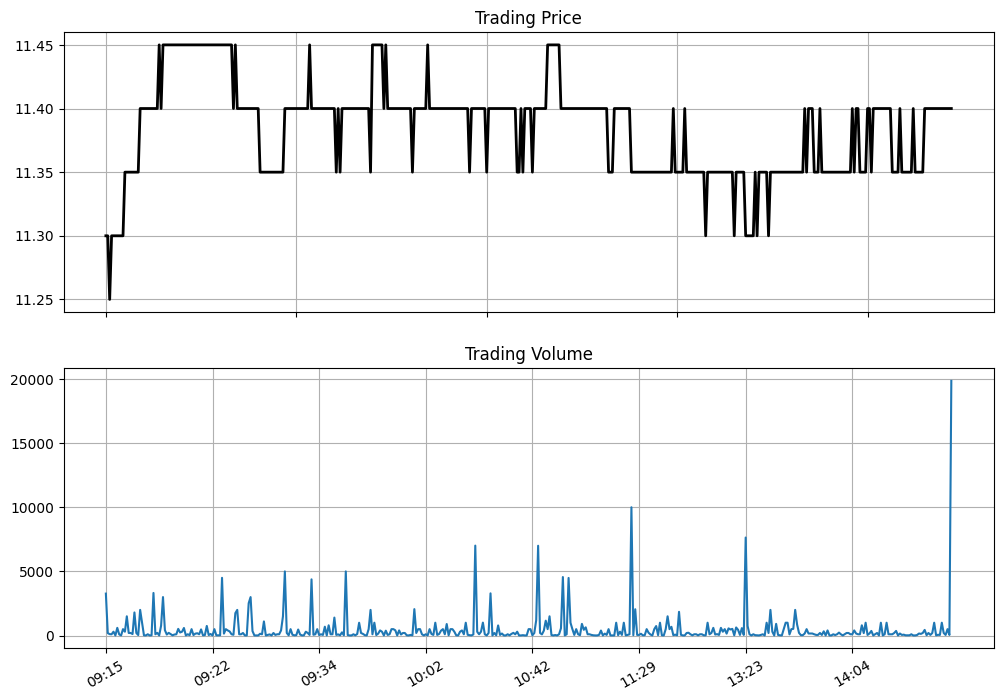

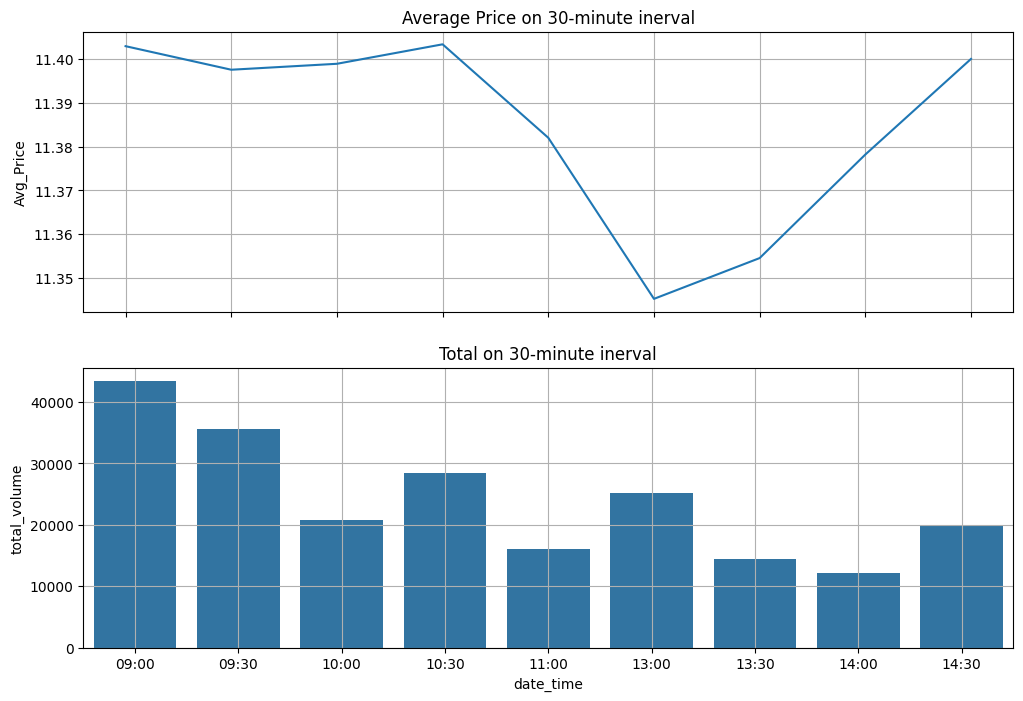

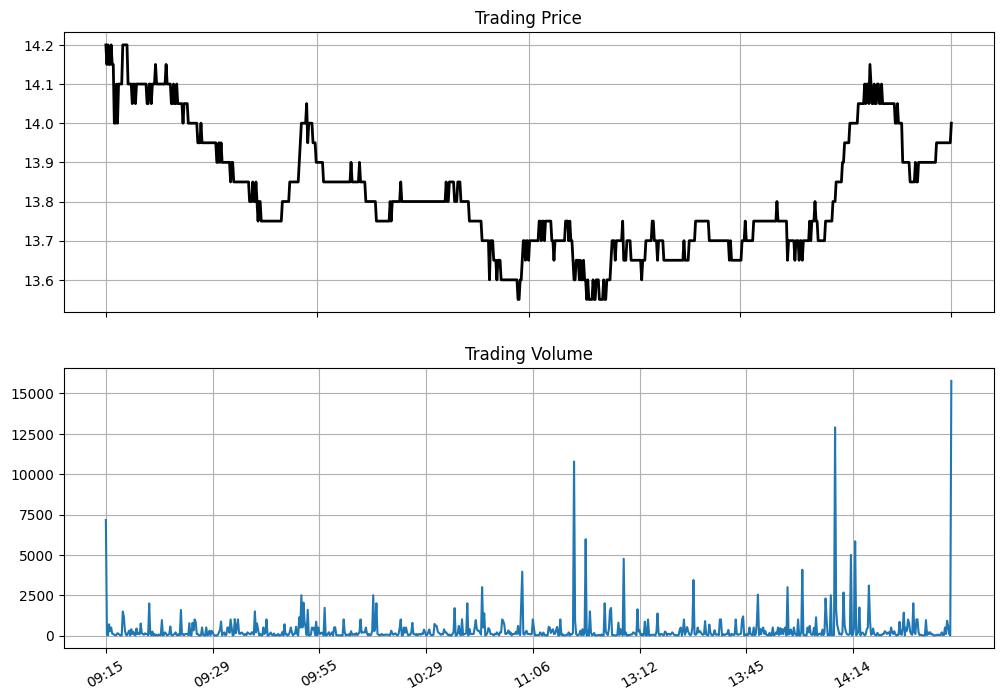

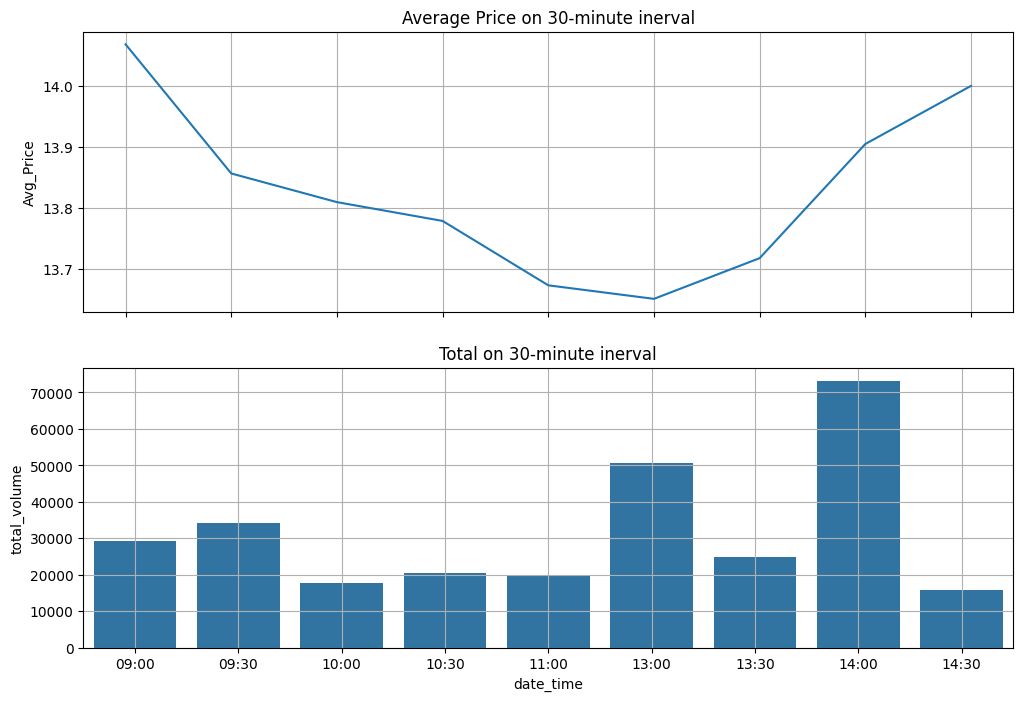

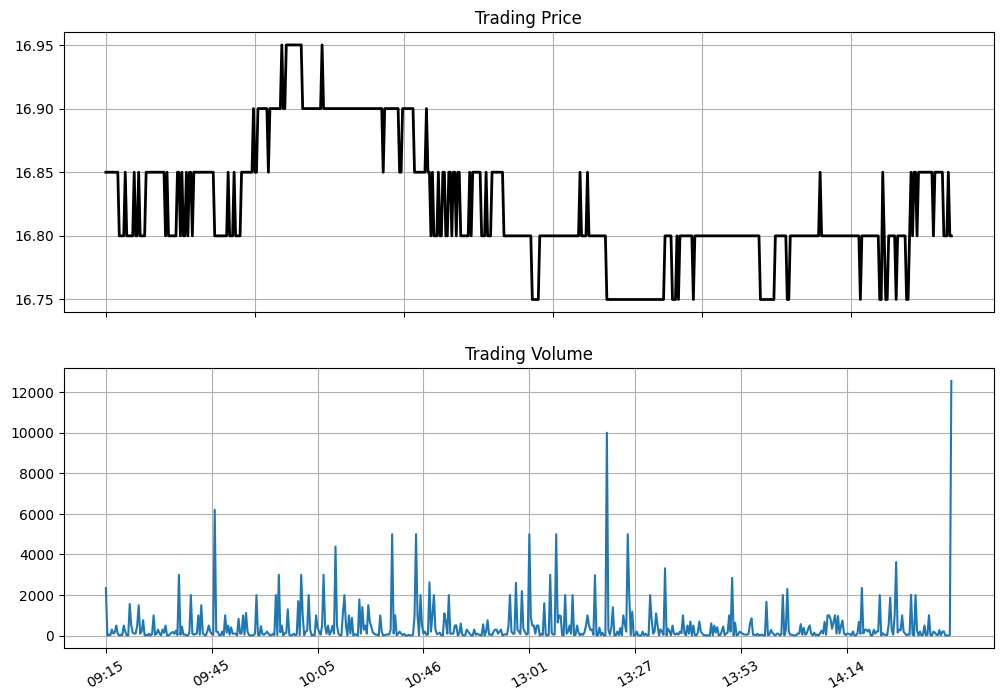

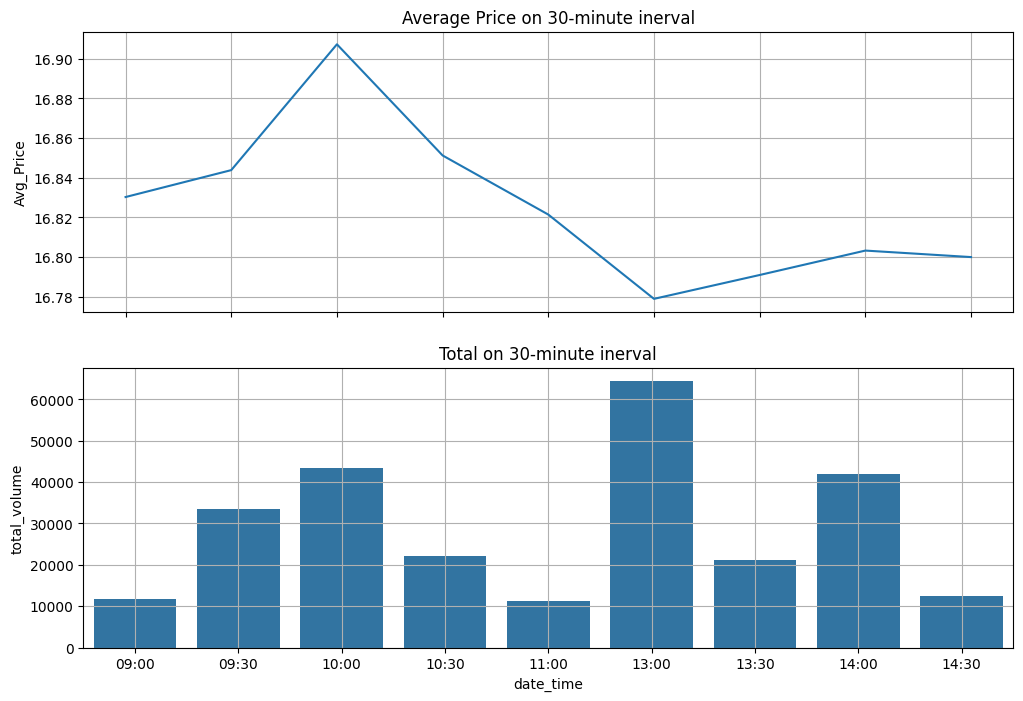

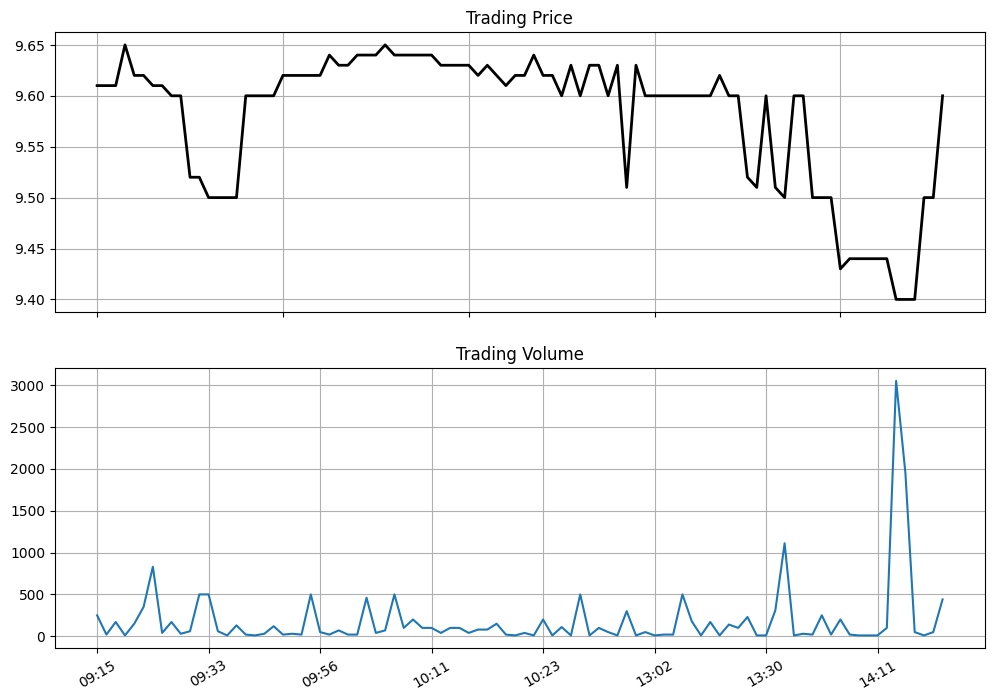

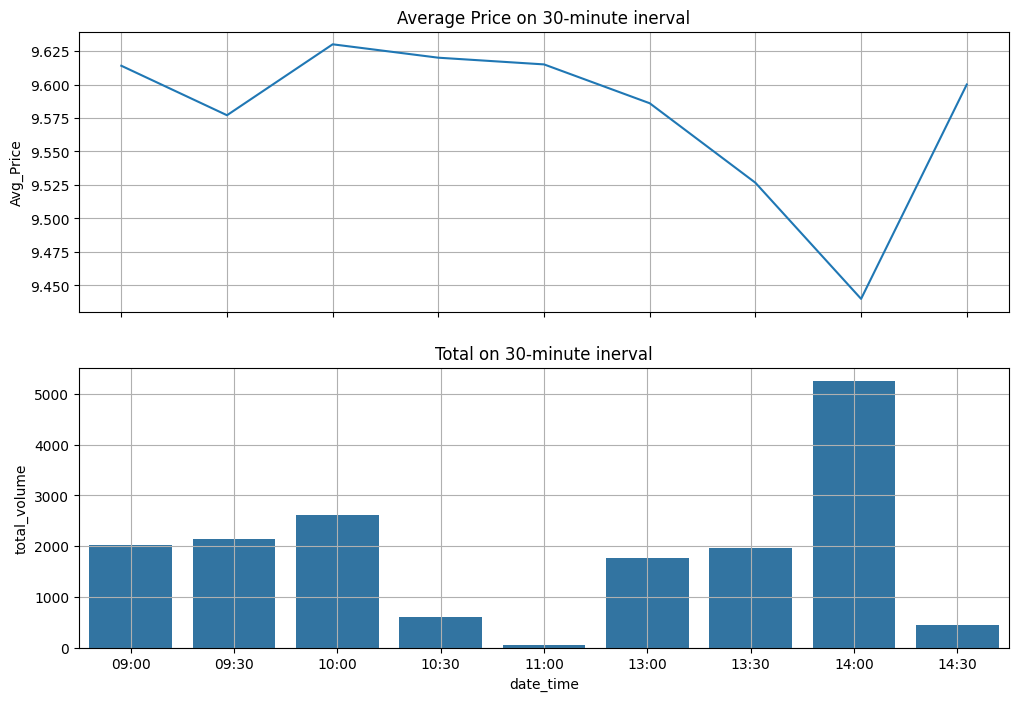

In [7]:
# All file
all_names = os.listdir(path) # list all name in a folder
for file in all_names:
    data = data_wrangling(path,file,date,save=False)
    abnormal = abnormal_trading_filtering(data,file,threshold=1000,save=True)
    general_plot(data,save=True)
    _ = interval_analysis(data,save=True)

In [189]:
# # Single file
# data = data_wrangling(path,file,date,save=False)
# # abnormal = abnormal_trading_filtering(data,file,threshold=1000,save=False)
# general_plot(data,save=False)
# _ = interval_analysis(data,save=False)

In [13]:
# file = 'VOS.xlsx'
# file = 'KHP.xlsx'
file = 'CII.xlsx'
# file = 'SBT.xlsx'
date = '14-05'
# date = datetime.today().strftime('%d-%m')
threshold = 2000
data = data_wrangling(path,file,date,save=False)
abnormal = abnormal_trading_filtering(data,file,threshold=threshold,save=True)
abnormal

,date_time,volume,price,pct
0,09:15:00,2340,16.85,0.10
49,09:36:16,3000,16.85,0.10
73,09:47:01,6200,16.80,0.05
116,09:58:14,3000,16.90,0.15
131,10:03:45,3000,16.95,0.20
146,10:06:29,3000,16.90,0.15
154,10:09:20,4390,16.90,0.15
192,10:26:24,5000,16.90,0.15
208,10:43:54,5000,16.85,0.10
217,10:49:17,2630,16.85,0.10


In [14]:
print(f'Abnormal trading accounts for {abnormal.volume.sum()/data.volume.sum() *100:.2f}% of intra-trading')

Abnormal trading accounts for 39.08% of intra-trading
